# MSE model with attenuation correction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.linear_model import LinearRegression
from utils import load_data, RegressionModel, train_model, plot_results

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

For this analysis, we use the "small dataset" with 10k samples selected at random from the full 60K DHS dataset. The data we use consists of latent representations of satllite images $X \in \mathbb{R}^{232}$ and corresponding International Wealth Index (IWI) values $y \in \mathbb{R}$ from survey data. For now, we use the same train-test splits for all experiments, but we should evaluate with cross-validation.

In [3]:
X_train, X_val, X_test, y_train, y_val, y_test = load_data()

Unless otherwised specified, we use the same basic regression model.

In [4]:
RegressionModel()

RegressionModel(
  (fc): Sequential(
    (0): Linear(in_features=232, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

# Model training

The helper function `train_model`, that creates and trains a `RegressionModel` using gradient descent, has the main arguments `X_train, X_val, y_train, y_val, loss_fn`. `loss_fn` is supposed to be a function that in addition to returning the loss to minimize should return a dict object with whatever metric you would like to log during training.

## MSE baseline

  4%|▍         | 2186/50000 [00:04<01:28, 538.03it/s]


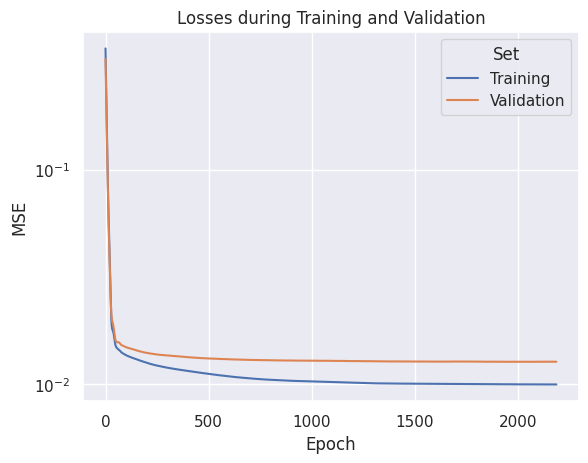

In [5]:
# Example of a loss function that only tracks one metric (MSE)
def mse_loss(pred, target):
    mse = nn.MSELoss()(pred, target)
    return mse, {'MSE': mse.item()}

mse_model = train_model(X_train, X_val, y_train, y_val, lr=1e-3, l2=1e-2, loss_fn=mse_loss, verbose=1)

When we plot the results, we see that the model suffers from attenuation error (the model overestimates wealth for poor places and underestimates for wealthy places).

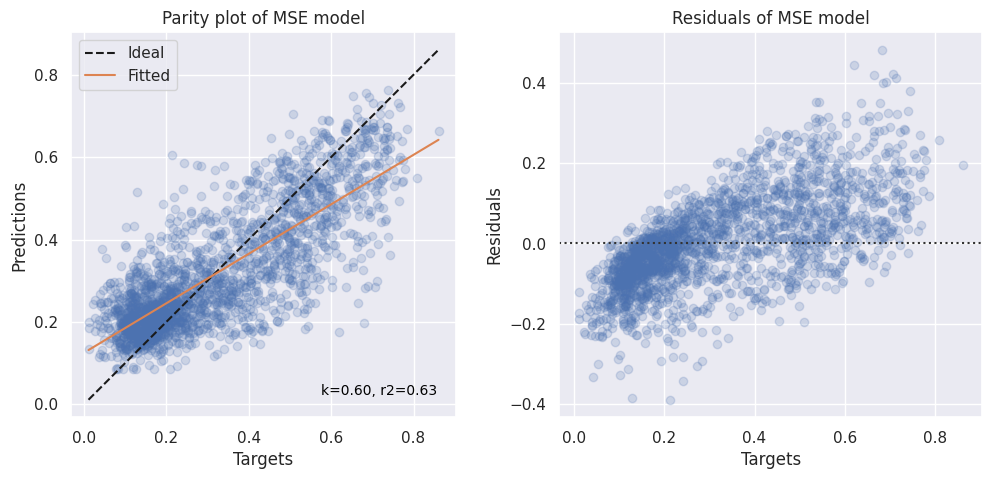

In [6]:
with torch.no_grad():
    y_pred = mse_model(X_test)
    
plot_results(y_test, y_pred, 'MSE model')

One idea is to simply correct for this by fitting a linear regression on the calibration data (should be a separate hold-out set later) and using the coefficients to "correct" the predictions

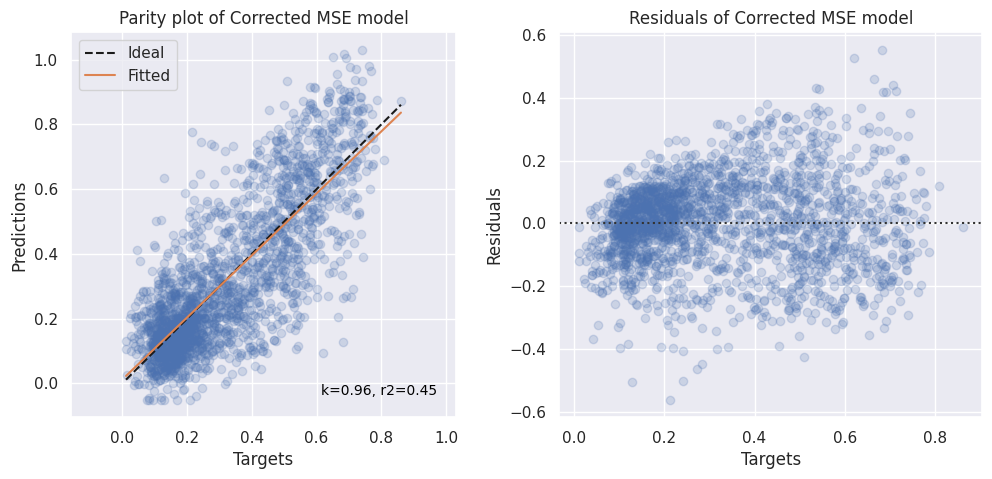

In [7]:
with torch.no_grad():
    y_pred_val = mse_model(X_val)
    slope_model = LinearRegression().fit(y_val.cpu().numpy().reshape(-1, 1), y_pred_val.cpu().numpy())
    
corrected_y_pred = (y_pred - slope_model.intercept_) / slope_model.coef_[0]

plot_results(y_test, corrected_y_pred, 'Corrected MSE model')

The correction causes $r^2$ to take a hit, but now the ATE estimate should be unbiased. That is, if you belive the relationship between $y$ and $\hat{y}$ to be linear.

This seems very similar to the correlation correction that I didn't manage to get to work properly in December. I believe the reason it didn't work then was that I calculated the correlation without accounting for a possible intercept $\neq 0$. This makes it seems like we do not need any fancy loss functions, as long as we perform this "correction". I see two potential drawbacks with this: 

1. If the relationship between $y$ and $\hat{y}$ is non-linear.
2. Their might be a better way fit the model without causeing as sharp of a drop-off in $r^2$. Perhaps we can solve this by applying the "correction" before calculating MSE loss during training? This would require us to fit an OLS for each training step. Maybe we can do something non-linear here too?

## What if we use an isotonic regressor instead of linear?

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator, UnivariateSpline, CubicSpline
from scipy.optimize import root_scalar
from sklearn.isotonic import IsotonicRegression

class IversableIsotonicRegressor:
    
    def __init__(self, spline_type='PCHIP', smooth_factor=0.5):
        self.iso_reg = IsotonicRegression(increasing=True, out_of_bounds="clip")
        self.spline_type = spline_type
        self.smooth_factor = smooth_factor  # Adjusts the smoothness
        # self.iso_reg = IsotonicRegression(increasing=True, out_of_bounds="clip")
    
    def fit(self, X, y):
        
        # Sort arrays by X
        p = X.argsort()
        X = X[p]
        y = y[p]

        # Remove duplicate X values by averaging corresponding y values
        X_unique, indices = np.unique(X, return_index=True)
        y_unique = np.array([np.mean(y[X == x]) for x in X_unique])
        
        y_mono = self.iso_reg.fit_transform(X_unique, y_unique)  # Now y_mono is strictly increasing
        
        if self.spline_type == 'PCHIP':
            self.monotonic_spline = PchipInterpolator(X_unique, y_mono)
        elif self.spline_type == 'Univariate':
            self.monotonic_spline = UnivariateSpline(X_unique, y_mono, s=self.smooth_factor)
        else:
            raise ValueError('Only PCHIP and Univariate splines are supported')
        
        self.bracket = [X_unique[0], X_unique[-1]]
        
    def inverse(self, y):
        """Find X_i for an array of y_values such that f(X_i) = y_values."""

        def find_root(y):
            """Find single root X_i for a given y_value."""
            def func(x):
                return self.monotonic_spline(x) - y
            
            # Return closest value if out of bracket
            if func(self.bracket[0]) > 0:
                return self.bracket[0]
            elif func(self.bracket[1]) < 0:
                return self.bracket[1]

            result = root_scalar(func, bracket=self.bracket, method='brentq')
            return result.root if result.converged else np.nan  # Return NaN if no solution

        # Apply the function to each y_value
        return np.array([find_root(y_i) for y_i in y])

In [41]:
with torch.no_grad():
    y_pred_val = mse_model(X_val)
    y_pred_test = mse_model(X_test)
    
iv_reg = IversableIsotonicRegressor(spline_type='Univariate', smooth_factor=15)
iv_reg.fit(y_val.cpu().numpy(), y_pred_val.cpu().numpy())


# Test inversion with multiple y_values
y_val_recovered = iv_reg.inverse(y_pred_val.cpu().numpy())
y_test_recovered = iv_reg.inverse(y_pred_test.cpu().numpy())

In [53]:
from tqdm import tqdm
from scipy import stats

y_pred_val_np = y_pred_val.cpu().numpy()
y_pred_test_np = y_pred_test.cpu().numpy()

y_val_np = y_val.cpu().numpy()
y_test_np = y_test.cpu().numpy()
        
iv_reg = IversableIsotonicRegressor(spline_type='Univariate', smooth_factor=s)
iv_reg.fit(y_val_np, y_pred_val_np)

# Test inversion with multiple y_values
y_val_recovered = iv_reg.inverse(y_pred_val_np)
y_test_recovered = iv_reg.inverse(y_pred_test_np)

slope_model = LinearRegression().fit(y_test_np.reshape(-1, 1), y_test_recovered)

# Calculate residuals
residuals = y_test_recovered - slope_model.predict(y_test_np.reshape(-1, 1))

# Calculate the residual sum of squares (RSS)
rss = np.sum(residuals**2)

# Calculate the standard error of the regression
n = len(y_test_np)  # Number of data points
p = 1  # Number of predictors (slope only, no intercept)
stderr = np.sqrt(rss / (n - p - 1)) / np.sqrt(np.sum((y_test_np - np.mean(y_test_np))**2))

# Get the coefficient (slope)
slope = slope_model.coef_[0]

# Degrees of freedom
df = n - p - 1

# t-statistic for 95% confidence level (two-tailed)
t_stat = stats.t.ppf(1 - 0.005, df)

# Calculate the confidence interval
ci_lower = slope - t_stat * stderr
ci_upper = slope + t_stat * stderr

# Print the slope and confidence interval
print(f"Estimated slope: {slope}")
print(f"95% Confidence Interval for the slope: ({ci_lower}, {ci_upper})")

  9%|▉         | 1/11 [00:00<00:04,  2.22it/s]

Estimated slope: 0.9662090539932251
95% Confidence Interval for the slope: (0.9219883360781604, 1.0104297719082898)


 18%|█▊        | 2/11 [00:00<00:02,  3.07it/s]

Estimated slope: 0.9800747036933899
95% Confidence Interval for the slope: (0.9352137897499908, 1.024935617636789)


 27%|██▋       | 3/11 [00:00<00:02,  3.49it/s]

Estimated slope: 0.9709616899490356
95% Confidence Interval for the slope: (0.9262055852748519, 1.0157177946232194)


 36%|███▋      | 4/11 [00:01<00:01,  3.73it/s]

Estimated slope: 0.9709616899490356
95% Confidence Interval for the slope: (0.9262055852748519, 1.0157177946232194)


 45%|████▌     | 5/11 [00:01<00:01,  3.87it/s]

Estimated slope: 0.9709616899490356
95% Confidence Interval for the slope: (0.9262055852748519, 1.0157177946232194)


 55%|█████▍    | 6/11 [00:01<00:01,  3.92it/s]

Estimated slope: 0.9709616899490356
95% Confidence Interval for the slope: (0.9262055852748519, 1.0157177946232194)


 64%|██████▎   | 7/11 [00:01<00:00,  4.00it/s]

Estimated slope: 0.9709616899490356
95% Confidence Interval for the slope: (0.9262055852748519, 1.0157177946232194)


 73%|███████▎  | 8/11 [00:02<00:00,  4.05it/s]

Estimated slope: 0.9709616899490356
95% Confidence Interval for the slope: (0.9262055852748519, 1.0157177946232194)


 82%|████████▏ | 9/11 [00:02<00:00,  4.09it/s]

Estimated slope: 0.9709616899490356
95% Confidence Interval for the slope: (0.9262055852748519, 1.0157177946232194)


 91%|█████████ | 10/11 [00:02<00:00,  4.12it/s]

Estimated slope: 0.9709616899490356
95% Confidence Interval for the slope: (0.9262055852748519, 1.0157177946232194)


100%|██████████| 11/11 [00:02<00:00,  3.82it/s]

Estimated slope: 0.9709616899490356
95% Confidence Interval for the slope: (0.9262055852748519, 1.0157177946232194)


In [59]:
2*(0.005)

0.01

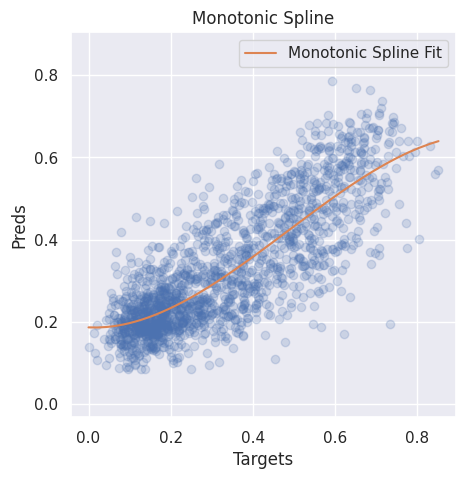

In [42]:
import seaborn as sns

p = np.argsort(y_val.cpu().numpy())
plot_y_val = y_val.cpu().numpy()[p]
plot_y_pred_val = y_pred_val.cpu().numpy()[p]


fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(plot_y_val, plot_y_pred_val, alpha=0.2)
y_pred = iv_reg.monotonic_spline(plot_y_val)
ax.plot(plot_y_val, y_pred, color=sns.color_palette()[1], label='Monotonic Spline Fit')

ax.set_aspect('equal', adjustable='box')
ax.set_box_aspect(1)

plt.legend()
plt.xlabel('Targets')
plt.ylabel('Preds')
plt.title('Monotonic Spline')
plt.show()

In [78]:

from sklearn.metrics import r2_score, mean_squared_error

def parity_plot(targets, predictions, title=None, ax=None):
    
    targets = targets.cpu().numpy()
    predictions = predictions.cpu().numpy()
    should_plot = False
    
    p = np.argsort(targets)
    targets = targets[p]
    predictions = predictions[p]

    slope_model = LinearRegression().fit(targets.reshape(-1, 1), predictions)

    # Create a new figure and axis if none is provided
    if ax is None:
        should_plot = True
        fig, ax = plt.subplots()

    #ax.scatter(targets, predictions, alpha=0.2)

    # Plot regression lines
    x = np.asarray([min(targets), max(targets)])
    ideal_y = x
    true_y = slope_model.predict(x.reshape(-1, 1))

    # Compute statistics and format the string
    stats_text = f'k={slope_model.coef_[0]:.2f}, r2={r2_score(targets, predictions):.2f}'

    ax.plot(x, ideal_y, 'k--', label='Ideal')
    sns.regplot(x=targets, y=predictions, label='Fitted', ax=ax, scatter_kws={'alpha':0.2})
    #ax.plot(x, true_y, c=sns.color_palette()[1], label='Fitted')
    ax.set_xlabel('Targets')
    ax.set_ylabel('Predictions')
    ax.set_title(title)
    ax.legend()

    # Add the text in the bottom-right corner
    ax.set_aspect('equal', adjustable='box')
    ax.set_box_aspect(1)  # Ensure the box is square
    ax.text(
        0.95, 0.05, stats_text,
        transform=ax.transAxes,
        fontsize=10, color='black', ha='right', va='bottom'
    )

    # Show the plot if no external axis was provided
    if should_plot:
        plt.show()

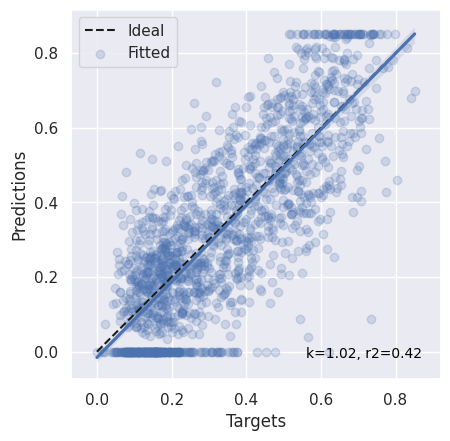

In [79]:
parity_plot(y_val, torch.tensor(y_val_recovered).cuda())

In [35]:
iv_reg = IversableIsotonicRegressor(spline_type='Univariate', smooth_factor=15)
iv_reg.fit(y_val.cpu().numpy(), y_pred_val.cpu().numpy())

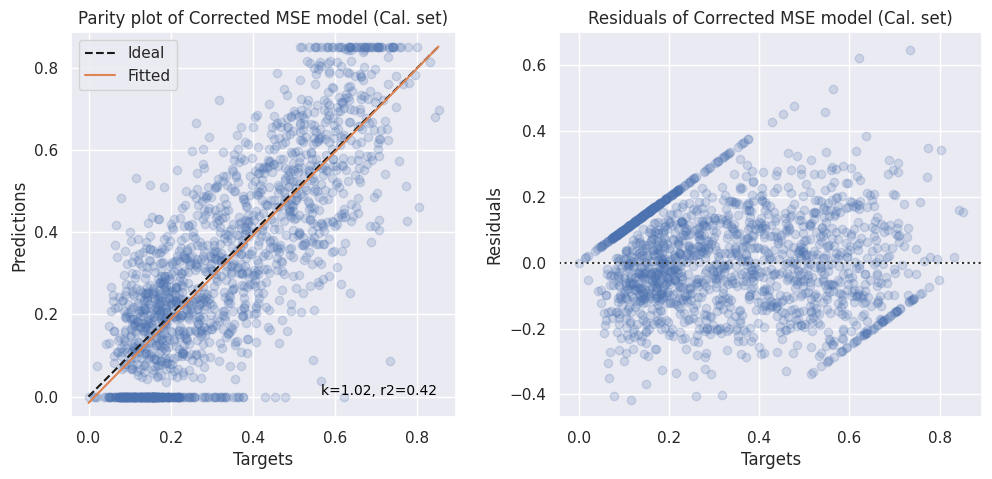

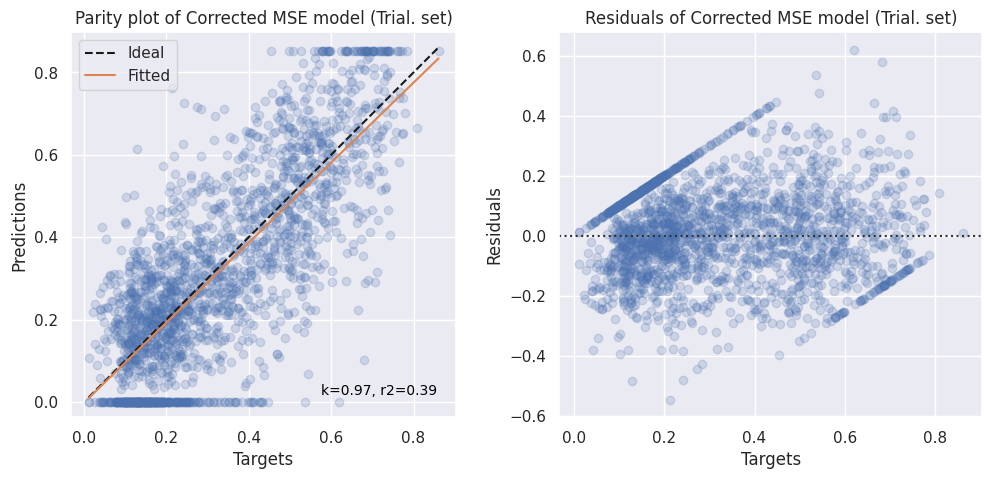

In [44]:
plot_results(y_val, torch.tensor(y_val_recovered).cuda(), 'Corrected MSE model (Cal. set)')
plot_results(y_test, torch.tensor(y_test_recovered).cuda(), 'Corrected MSE model (Trial. set)')